# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.



## Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

### Preface: Some code to get you started

What follows is some **very simple** code for training an MLP on MNIST. The point of this code is to get you up and running (and to verify that your Python environment has all needed dependencies).

**Note**: As you read through my code and execute it, this would be a good time to think about *abstracting* **your** model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

In [ ]:
# Start with some standard imports.
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torchvision.datasets import MNIST
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import wandb

#### Data preparation

Here is some basic dataset loading, validation splitting code to get you started working with MNIST.

In [ ]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test.
ds_train = MNIST(root='~/datasets', train=True, download=True, transform=transform)
ds_test = MNIST(root='~/datasets', train=False, download=True, transform=transform)

# Split train into train and validation.
val_size = 5000
I = np.random.permutation(len(ds_train))
ds_val = Subset(ds_train, I[:val_size])
ds_train = Subset(ds_train, I[val_size:])

#### Boilerplate training and evaluation code

This is some **very** rough training, evaluation, and plotting code. Again, just to get you started. I will be *very* disappointed if any of this code makes it into your final submission.

In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Function to train a model for a single epoch over the data loader.
def train_epoch(model, dl, opt, epoch='Unknown', device='cpu'):
    model.train()
    losses = []
    for (xs, ys) in tqdm(dl, desc=f'Training epoch {epoch}', leave=True):
        xs = xs.to(device)
        ys = ys.to(device)
        opt.zero_grad()
        logits = model(xs)
        loss = F.cross_entropy(logits, ys)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    return np.mean(losses)

# Function to evaluate model over all samples in the data loader.
def evaluate_model(model, dl, device='cpu'):
    model.eval()
    predictions = []
    gts = []
    for (xs, ys) in tqdm(dl, desc='Evaluating', leave=False):
        xs = xs.to(device)
        preds = torch.argmax(model(xs), dim=1)
        gts.append(ys)
        predictions.append(preds.detach().cpu().numpy())
        
    # Return accuracy score and classification report.
    return (accuracy_score(np.hstack(gts), np.hstack(predictions)),
            classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3))

# Simple function to plot the loss curve and validation accuracy.
def plot_validation_curves(losses_and_accs):
    losses = [x for (x, _) in losses_and_accs]
    accs = [x for (_, x) in losses_and_accs]
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss per Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(accs)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {np.max(accs)} @ epoch {np.argmax(accs)}')

#### A basic, parameterized MLP

This is a very basic implementation of a Multilayer Perceptron. Don't waste too much time trying to figure out how it works -- the important detail is that it allows you to pass in a list of input, hidden layer, and output *widths*. **Your** implementation should also support this for the exercises to come.

In [ ]:
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(nin, nout) for (nin, nout) in zip(layer_sizes[:-1], layer_sizes[1:])])
    
    def forward(self, x):
        return reduce(lambda f, g: lambda x: g(F.relu(f(x))), self.layers, lambda x: x.flatten(1))(x)

#### A *very* minimal training pipeline.

Here is some basic training and evaluation code to get you started.

**Important**: I cannot stress enough that this is a **terrible** example of how to implement a training pipeline. You can do better!

In [ ]:
# Training hyperparameters.
device = 'cuda'
epochs = 10
lr = 0.0001
batch_size = 128

# Architecture hyperparameters.
input_size = 28*28
width = 16
depth = 2

# Dataloaders.
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

# Instantiate model and optimizer.
model_mlp = MLP([input_size] + [width]*depth + [10]).to(device)
opt = torch.optim.Adam(params=model_mlp.parameters(), lr=lr)


In [ ]:

# Instantiate model and optimizer.
model_mlp = MLP([input_size] + [width]*depth + [10]).to(device)
opt = torch.optim.Adam(params=model_mlp.parameters(), lr=lr)

# Training loop.
losses_and_accs = []
for epoch in range(epochs):
    loss = train_epoch(model_mlp, dl_train, opt, epoch, device=device)
    (val_acc, _) = evaluate_model(model_mlp, dl_val, device=device)
    losses_and_accs.append((loss, val_acc))

# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST:\n {evaluate_model(model_mlp, dl_test, device=device)[1]}')

### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.# Your code here.

In [ ]:
class BaselineMLP(nn.Module):

    def __init__(self, input_size, embedding_size, depth, n_classes) -> None:
        super().__init__()
        self.input = nn.Linear(input_size, embedding_size)
        self.network = nn.ModuleList(
                [nn.Linear(embedding_size, embedding_size) for _ in range(depth)]
        )
        self.head = nn.Linear(embedding_size, n_classes)

    def forward(self, X):
        X = X.flatten(1)
        X = F.relu(self.input(X))
        for layer in self.network:
            X = F.dropout(F.relu(layer(X)), 0.6)
        return self.head(X)

# My Training + Eval

In [101]:
def get_max_grad(model: nn.Module):
    maxG = 0
    for par in model.parameters():
        maxG = max(torch.linalg.vector_norm(par.grad.data.flatten()).item(), maxG)
    return maxG

In [ ]:
@torch.no_grad()
def validation(model, dataloader, loss_fn):
    model.eval()
    loss = 0
    acc = 0
    for x, y in tqdm(dataloader, "Validation: ", leave=False):
        x, y = x.to(device), y.to(device)
        prediction_logits = model(x)
        loss += loss_fn(prediction_logits, y).item()
        acc += (prediction_logits.argmax(1) == y).float().sum().item()
    return loss / len(dataloader), acc / len(dataloader.dataset)

In [109]:
def training(model, train_dataloader, validation_dataloader, loss_fn, optimizer, epochs, validation_freq, log, log_weights):
    losses, accs, mgs = [], [], []
    for t in range(1, epochs + 1):
        model.train()
        for x, y in tqdm(train_dataloader, f"Epoch #{t}: ", leave=False):
            x, y = x.to(device), y.to(device)
            prediction_logits = model(x)
            loss = loss_fn(prediction_logits, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if epoch % validation_freq == 0:
            lss, acc = validation(model, validation_dataloader, loss_fn)
            losses.append(lss)
            accs.append(acc)
            log_dict = {"loss": lss, "accuracy": acc}
            mg = get_max_grad(model)
            mgs.append(mg)
            if log_weights:
                log_dict['max_grad'] = mg
            if log:
                wandb.log(log_dict)

    return losses, accs, mgs

In [111]:
def plot_training_result(losses, accs, mgs, freq):
    x = [i * freq for i in range(1, len(losses) + 1)]
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
    ax1.plot(x, losses)
    ax2.plot(x, accs)
    ax3.plot(x, mgs)
    fig.show()

In [103]:
mlp = BaselineMLP(28**2, 1024, 2, 10).to(device)
loss = F.cross_entropy
opt = torch.optim.Adam(mlp.parameters(), lr=0.001)
l, a, g = training(mlp, dl_train, dl_val, loss, opt, 15, 1, False, False)

KeyboardInterrupt: 

In [ ]:
plot_training_result(l, a, 1)

### Exercise 1.2: Rinse and Repeat

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Spoiler**: If you plan to do optional exercise 3.3, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

In [ ]:
def conv_3x3_same_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels), 
        nn.ReLU()
    )

def conv_3x3_valid_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=0),
        nn.MaxPool2d(3, stride=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

In [ ]:
class CNN(nn.Module): 
    def __init__(self, res, input_channels, embedding_filters, depth, n_classes) -> None:
        super(CNN, self).__init__()
        self.input = nn.Sequential(*[
            conv_3x3_valid_block(input_channels, embedding_filters // 4), 
            conv_3x3_valid_block(embedding_filters // 4, embedding_filters // 2), 
            conv_3x3_valid_block(embedding_filters // 2, embedding_filters)
        ])
        self.net = nn.Sequential(*[
            conv_3x3_same_block(embedding_filters, embedding_filters)
        for _ in range(depth)])
        self.out = nn.Sequential(
            nn.Flatten(),
            nn.Linear(((res - 12) ** 2) * embedding_filters, n_classes)
        )
    def forward(self, X):
        X = self.input(X)
        X = self.net(X)
        return self.out(X)

In [ ]:
cnn = CNN(28, 1, 32, 3, 10).to(device)
loss = F.cross_entropy
opt = torch.optim.Adam(cnn.parameters(), lr=0.001)
l, a = training(cnn, dl_train, dl_val, loss, opt, 15, 1, False, False)

/tmp/ipykernel_5068/3201781093.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


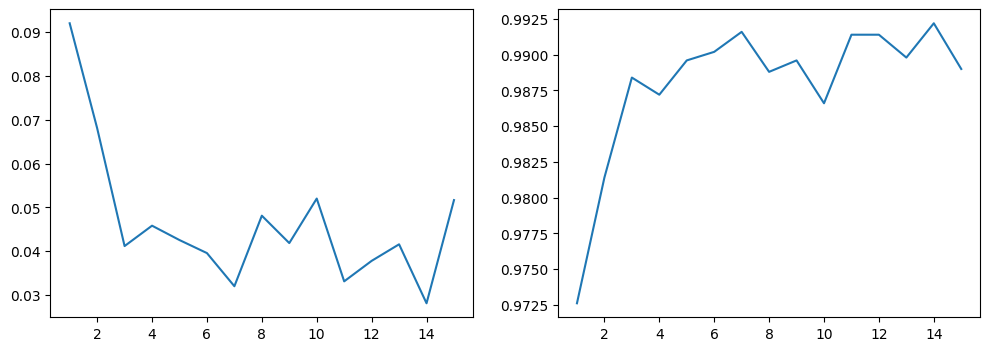

In [94]:
plot_training_result(l, a, 1)

# CIFAR10 DS

In [95]:
from torch.utils.data import random_split
from torchvision.datasets import CIFAR10
# Standard CIFAR transform.
transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

cifar_train = CIFAR10("~/datasets", download=True, transform=transform_cifar)
cifar_train, cifar_val = random_split(cifar_train, (0.7, 0.3))
cifar_test = CIFAR10("~/datasets", download=True, transform=transform_cifar)

bsz = 64

cifar_dl_train = torch.utils.data.DataLoader(cifar_train, shuffle=True, batch_size=bsz)
cifar_dl_val = torch.utils.data.DataLoader(cifar_val, shuffle=True, batch_size=bsz)
cifar_dl_test = torch.utils.data.DataLoader(cifar_test, shuffle=True, batch_size=bsz)


Files already downloaded and verified
Files already downloaded and verified


Epoch #1:   0%|          | 0/547 [00:00<?, ?it/s]

/tmp/ipykernel_5068/3201781093.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(0.6510337003509102, 0.78522)


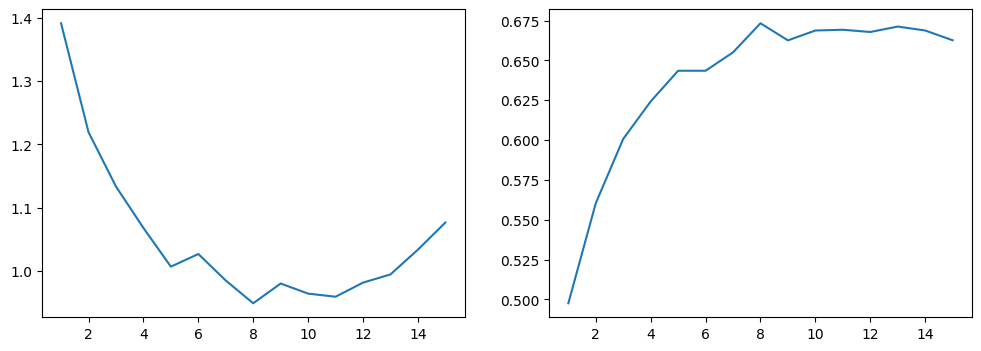

In [97]:
cnn = CNN(32, 3, 32, 3, 10).to(device)
loss = F.cross_entropy
opt = torch.optim.Adam(cnn.parameters(), lr=0.001)
l, a = training(cnn, cifar_dl_train, cifar_dl_val, loss, opt, 15, 1, False, False)
plot_training_result(l, a, 1)
print(validation(cnn, cifar_dl_test, loss))

-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit.

### Exercise 2.1: Explain why Residual Connections are so effective
Use your two models (with and without residual connections) you developed above to study and **quantify** why the residual versions of the networks learn more effectively.

**Hint**: A good starting point might be looking at the gradient magnitudes passing through the networks during backpropagation.

Epoch #1:   0%|          | 0/547 [00:00<?, ?it/s]

/tmp/ipykernel_5068/1515018894.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(0.7404560917021369, 0.74548)


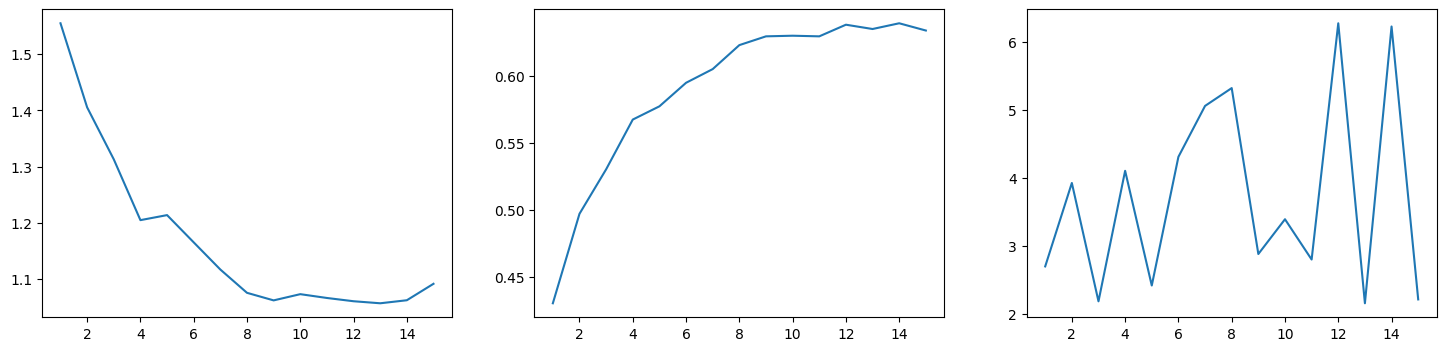

In [112]:
width = 32
depth = 10

cnn = CNN(32, 3, width, depth, 10).to(device)
loss = F.cross_entropy
opt = torch.optim.Adam(cnn.parameters(), lr=0.001)
# wandb.init(project="DLA LAB 1 2.1", config={
#     "architecture": "cnn",
#     "depth": depth,
#     "dataset": "cifar10"
# })
l, a, g = training(cnn, cifar_dl_train, cifar_dl_val, loss, opt, 15, 1, False, False)
# wandb.finish()
plot_training_result(l, a, g, 1)
print(validation(cnn, cifar_dl_test, loss))

In [114]:
class RCNN(nn.Module): 
    def __init__(self, res, input_channels, embedding_filters, depth, n_classes) -> None:
        super(RCNN, self).__init__()
        self.input = nn.Sequential(*[
            conv_3x3_valid_block(input_channels, embedding_filters // 4), 
            conv_3x3_valid_block(embedding_filters // 4, embedding_filters // 2), 
            conv_3x3_valid_block(embedding_filters // 2, embedding_filters)
        ])
        self.net = nn.ModuleList([
            conv_3x3_same_block(embedding_filters, embedding_filters)
        for _ in range(depth)])
        self.out = nn.Sequential(
            nn.Flatten(),
            nn.Linear(((res - 12) ** 2) * embedding_filters, n_classes)
        )
    def forward(self, X):
        X = self.input(X)
        for layer in self.net:
            X = X + layer(X)
        return self.out(X)

Epoch #1:   0%|          | 0/547 [00:00<?, ?it/s]

/tmp/ipykernel_5068/1515018894.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(0.6142309792816182, 0.84636)


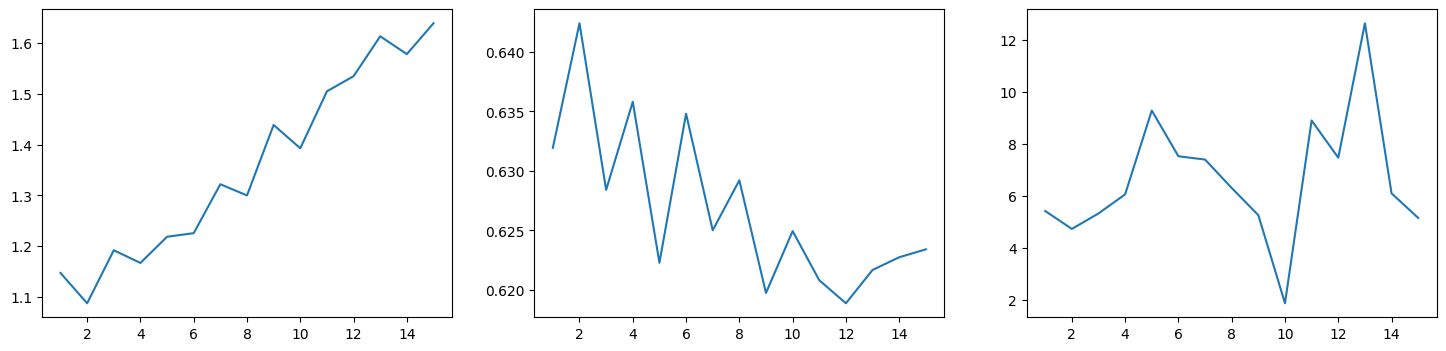

In [115]:
rcnn = RCNN(32, 3, width, depth, 10).to(device)
loss = F.cross_entropy
opt = torch.optim.Adam(cnn.parameters(), lr=0.001)
# wandb.init(project="DLA LAB 1 2.1", config={
#     "architecture": "cnn",
#     "depth": depth,
#     "dataset": "cifar10"
# })
l, a, g = training(cnn, cifar_dl_train, cifar_dl_val, loss, opt, 15, 1, False, False)
# wandb.finish()
plot_training_result(l, a, g, 1)
print(validation(cnn, cifar_dl_test, loss))

### Exercise 2.2: Fully-convolutionalize a network.
Take one of your trained classifiers and **fully-convolutionalize** it. That is, turn it into a network that can predict classification outputs at *all* pixels in an input image. Can you turn this into a **detector** of handwritten digits? Give it a try.

**Hint 1**: Sometimes the process of fully-convolutionalization is called "network surgery".

**Hint 2**: To test your fully-convolutionalized networks you might want to write some functions to take random MNIST samples and embed them into a larger image (i.e. in a regular grid or at random positions).

In [ ]:
# Your code here.

### Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.2 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes.

In [ ]:
# Your code here.